# RTA Freeway Travel Time Prediction
## A time series problem

### Overview
Why and How do predict travel time on a freeway from past travel time observations? 
Forecasting travel times helps improve road safety and efficiency. Accurate predictions help commuters make informed decisions about when to travel and on what routes. 

To develop the predictive model, I explore how to retrieve CSV dataset, how to transform the dataset into times series, exploratory data analysis (EDA) to figure out any insight from the data, testing if the time series is stationary or not using graphical and Dickey-Fuller test statistic methods, how to transform time series to stationary, how to decompose the time series, testing seasonality, and a way to find optimal parameters to build SARIMA model using grid search method. I am also diagnosing time series prediction, validating the predictive power, forecasting future travelling  on the 40140 segment of M4 highway in Sydney, as depicted below.

<img src="files/pic.png">

## Outline:
1. Introduction
 - Basic definitions
 - Quality metrics
2. Exploratory data analysis (EDA)
 - Loading and handling time series in Pandas
 - Cleansing 
 - Visualisation
3. Predictive models
  - Test stationary
     - Graphically test stationary
     - Test stationarity using Dickey-Fuller test
     - Transform the dataset to stationary
  - Decomposition
     - Trend
     - Seasonality/univarient
  - Find optimal parameters and build SARIMA model
  - Feature extraction
  - Define a mask to create a holiday categorical feature
  - Linear models, feature importance
  - Regularization, feature selection
  - Validating prediction
4. Future works
5. Questions
  - How model changes when factors are imported?  
  - What is the approach in rare events such as an accident?
   
     
  


## Introduction

This notebook addresses the problem of predicting travel time on Sydney's M4 freeway from past travel time observations. This is very important since it imptoves the general efficiency of the road transport system in Sydney.
The most frequent questions might be asked are: what will happen in the next day/week/month/etc or how many cares are passing in a particular time? What is the average travelling time or is there any trend on this road, etc?

As you know, time series is a series of data points indexed (or listed or graphed) in time order. Note that, to analyse this time series problem, stasmodels library of Python is used.

I use ''Mean absolute error'' and ''Root mean squared error'' metrics to compare time series sets because MAE is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the ''median'', while minimising the RMSE will lead to forecasts of the ''mean''.


### Exploratory data analysis (EDA)

#### Import libraries

In [59]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import os
import sys
import time
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from pylab import rcParams
import itertools
import statsmodels.tsa.api as smt
from itertools import product
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9

In [125]:
#Load csv
RTA_file="/Dropbox/.../40140.csv"
df_RTA = pd.read_csv(RTA_file, parse_dates=['Date'], index_col='Date',dayfirst=True)
df_RTA.head(n=1)

,travel_time,Time
Date,,
2010-03-02,1042,6:01:00


In [126]:
df_RTA[['travel_time','Time']].describe().loc['count']

travel_time    24507
Time           30161
Name: count, dtype: object

Note: why the counts are different? Maybe non values are in the "travel_time". Let's see, it seems non values are there

In [128]:
#null value
index_null=pd.isnull(df_RTA).any(1).nonzero()[0]
print("travel_time NULL count",  index_null.size)

('travel_time NULL count', 5654)


Note: let's fill up the non values. So, those are filled by the avarage of travelling time of the orresponding time. For example, the average of all "06:01:00" is considered for the miss value of the same times. 

In [129]:
index_null=pd.isnull(df_RTA).any(1).nonzero()[0]
index_x=np.where(df_RTA['travel_time']=='x')
index1=np.concatenate((index_null,index_x),axis=None)
for i in range(index_1.size):
    d=df_RTA[(df_RTA.travel_time.notnull()) & (df_RTA.travel_time!='x') ]
    m=(d['travel_time'][d['Time']==df_RTA.iloc[index1[i]]['Time']]).median()
    df_RTA.iloc[index1[i]].travel_time=m
    df_RTA.iloc[index1[i]]=df_RTA.iloc[index1[i]].fillna(m)
    df_RTA.iloc[index1[i]]=df_RTA.iloc[index1[i]].replace('x',m)


Note: the travel_time feature needs to be integer. So, 

In [130]:
df_RTA['travel_time'] = df_RTA['travel_time'].astype(int)

In [131]:
df_RTA['travel_time'].describe()

count    30161.000000
mean      1072.350950
std        348.300631
min        938.000000
25%       1039.000000
50%       1074.000000
75%       1076.000000
max      15885.000000
Name: travel_time, dtype: float64

Note: as the above shows, why the max is far away of the mean, however std is not that much big? I need to figure out more. May be a few accidents? 

Now, let's create a time series and make a plot to see more

The below shows the frequency of a day

In [132]:
df_RTA.index
ts = df_RTA['travel_time']
ts.head(5)
#The frequency of a day
ts.groupby(level=0).count()[:3]

Date
2010-03-02    120
2010-03-03    120
2010-03-04    120
Name: travel_time, dtype: int64

The below shows the average of travelling of a day

In [133]:
#The average of travelling of a day
ts.resample('D').mean()[:3]

Date
2010-03-02    1039.575000
2010-03-03    1053.933333
2010-03-04    1073.650000
Freq: D, Name: travel_time, dtype: float64

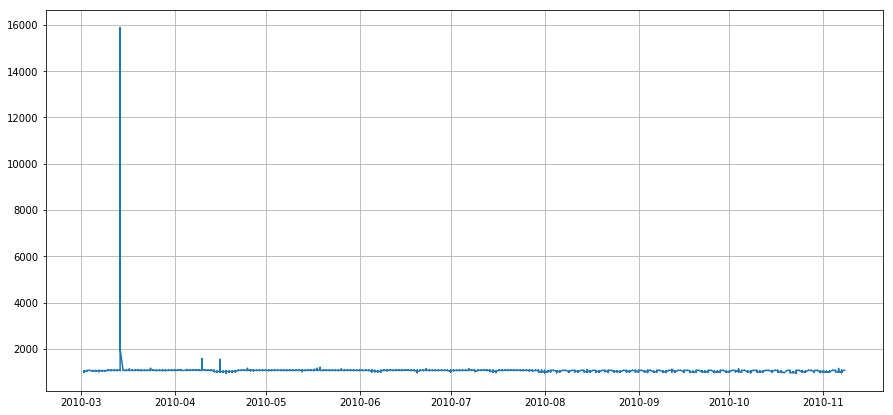

In [134]:
plt.figure(figsize=(15, 7))
plt.plot(ts)
plt.grid(True)
plt.show()

Note: A few outliers??? Let's find it.

In [135]:
outlier=np.where(df_RTA['travel_time']>1500)
for i in range(len(outlier)):
    print df_RTA.iloc[outlier[i]]

            travel_time      Time
Date                             
2010-03-14         1827   9:34:00
2010-03-14         3021   9:37:00
2010-03-14         2493   9:40:00
2010-03-14         4482   9:43:00
2010-03-14         4335   9:46:00
2010-03-14         3362   9:49:00
2010-03-14         3846   9:52:00
2010-03-14         6574   9:55:00
2010-03-14         5467   9:58:00
2010-03-14         7991  10:01:00
2010-03-14         5531  10:04:00
2010-03-14         5614  10:07:00
2010-03-14         6960  10:10:00
2010-03-14         7942  10:13:00
2010-03-14         7899  10:16:00
2010-03-14         8561  10:19:00
2010-03-14         7759  10:22:00
2010-03-14         9956  10:25:00
2010-03-14        11735  10:28:00
2010-03-14        10717  10:31:00
2010-03-14        10238  10:34:00
2010-03-14         9531  10:37:00
2010-03-14        10327  10:40:00
2010-03-14        12683  10:43:00
2010-03-14        13638  10:46:00
2010-03-14         9580  10:49:00
2010-03-14         9966  10:52:00
2010-03-14    

Note, as seen above, please see the three days of "2010-03-14" (most of the time), "2010-03-14" (from 11:19:00), and "2010-04-16 " (from 10:19:00). The easyiest way is to deal with similar to the above-mentioning scenario of missing values, or, the same day of another week

/home/amin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/amin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/amin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


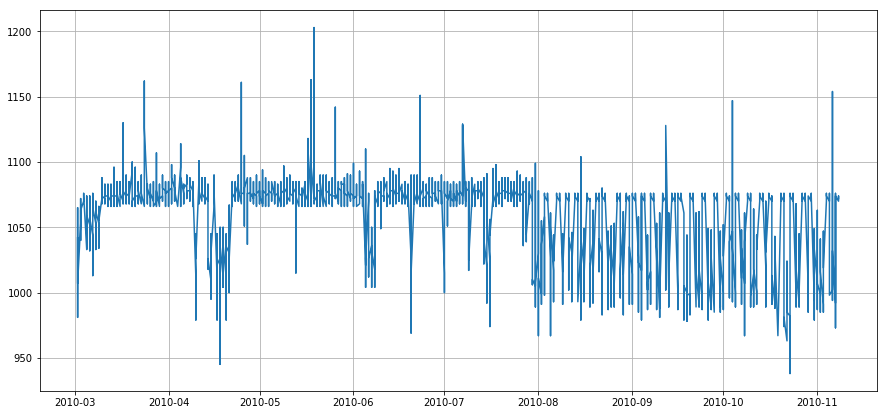

In [136]:
ts[df_RTA.index== '2010-03-14']=ts[df_RTA.index== '2010-03-21']
ts[df_RTA.index== '2010-04-10']=ts[df_RTA.index== '2010-04-17']
ts[df_RTA.index== '2010-04-16']=ts[df_RTA.index== '2010-05-23']
plt.figure(figsize=(15, 7))
plt.plot(ts)
plt.grid(True)
plt.show()


## Check Stationarity 

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? 

Two ways to check stationary:
 - A formal way of testing stationarity of a dataset is using plotting the moving average or moving variance and see if the series mean and variance varies with time. 
 - The second way to test stationarity is to use the statistical test (the Dickey-Fuller Test). The null hypothesis for the test is that the time series is non-stationary. The test results compare a Test Statistic and Critical Values (cutoff value) at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

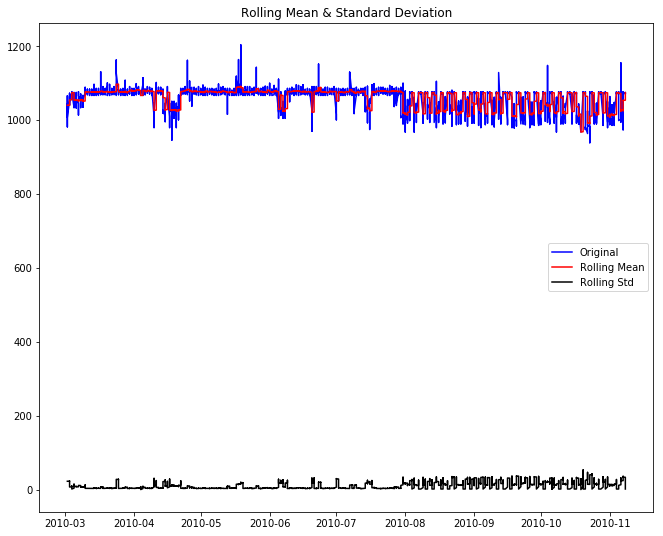

Results of Dickey-Fuller Test:
Test Statistic                -1.102877e+01
p-value                        5.738334e-20
#Lags Used                     1.000000e+01
Number of Observations Used    3.015000e+04
Critical Value (5%)           -2.861636e+00
Critical Value (1%)           -3.430567e+00
Critical Value (10%)          -2.566821e+00
dtype: float64


In [139]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(120).mean()
    rolstd = timeseries.rolling(120).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
test_stationarity(ts)

As seen, it is sationary. Otherwise, other techniques such as moving average, multi-level of differencing, and transformation are helpful. Sometimes exponentially weighted moving average technique where weights are assigned to all the previous values with a decay factor is also important.

For example: 

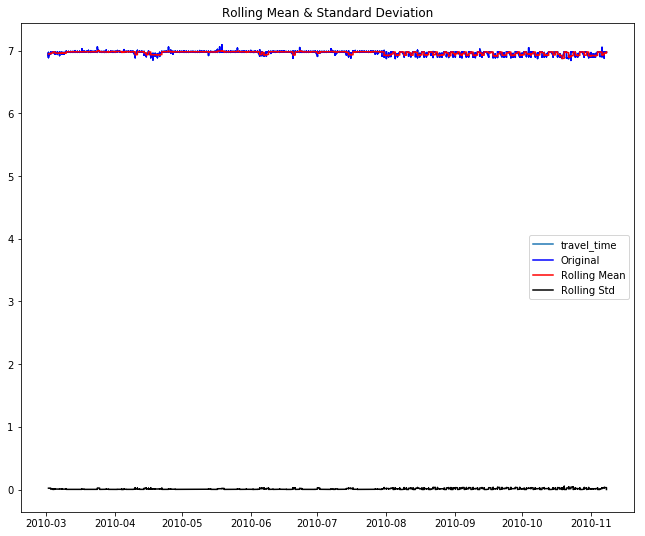

Results of Dickey-Fuller Test:
Test Statistic                -1.080051e+01
p-value                        2.023459e-19
#Lags Used                     3.900000e+01
Number of Observations Used    3.012100e+04
Critical Value (5%)           -2.861636e+00
Critical Value (1%)           -3.430567e+00
Critical Value (10%)          -2.566821e+00
dtype: float64


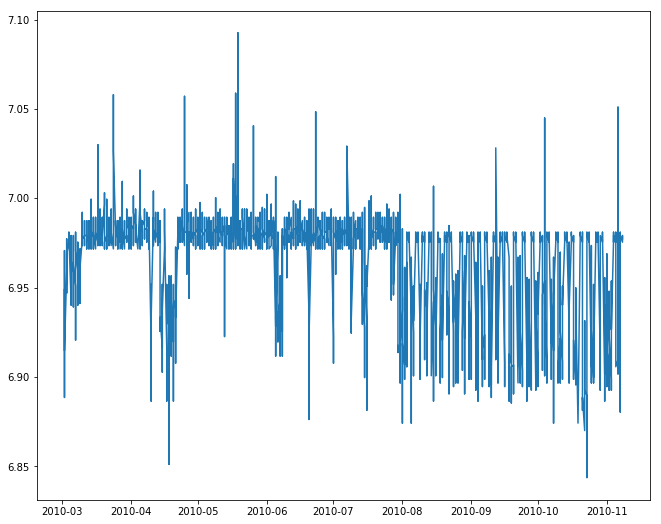

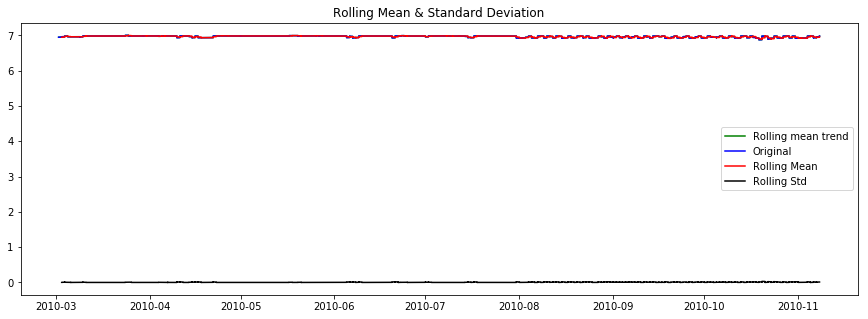

Results of Dickey-Fuller Test:
Test Statistic                -1.196392e+01
p-value                        4.041904e-22
#Lags Used                     3.500000e+01
Number of Observations Used    3.000600e+04
Critical Value (5%)           -2.861636e+00
Critical Value (1%)           -3.430568e+00
Critical Value (10%)          -2.566821e+00
dtype: float64


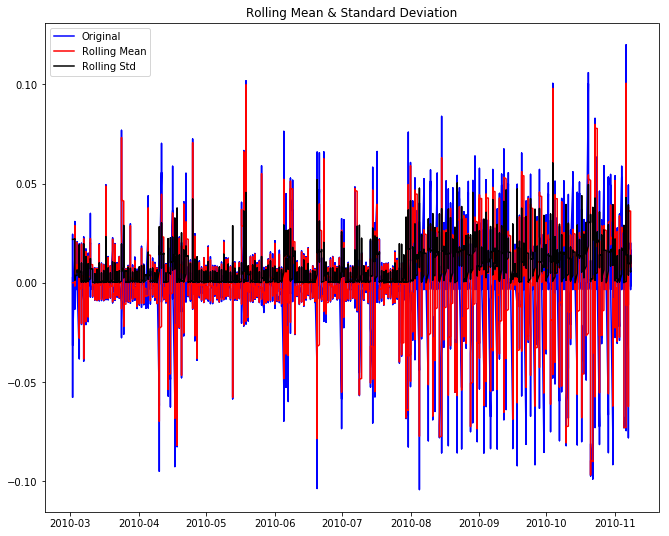

Results of Dickey-Fuller Test:


MemoryError: 

In [140]:
ts_log = np.log(ts)
plt.plot(ts_log)
test_stationarity(ts_log)

moving_avg = ts_log.rolling(120).mean()
plt.plot(ts_log)

plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(120))
plt.plot(moving_avg, "g", label="Rolling mean trend")

moving_avg.dropna(inplace=True)
test_stationarity(moving_avg)

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(120)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Just in case, let's eliminate trend and seasonality, if it does, by:
 - Differencing
 - Decomposition
 

Is the time series additive or multiplicative? In an additive time series, the components add together to make the time series. If you have an increasing trend, you still see roughly the same size peaks and troughs throughout the time series.

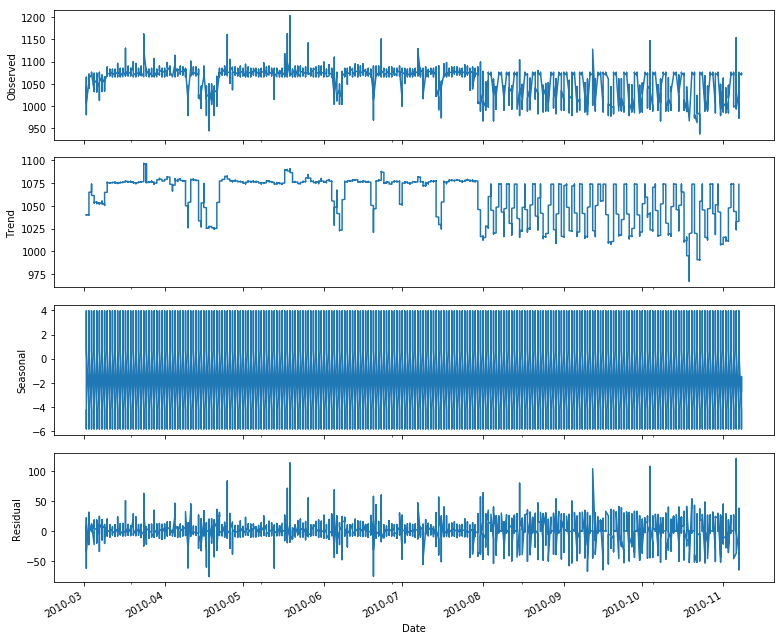

In [141]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive',freq=120)
fig = decomposition.plot()
plt.show()

Herem we can see that the trend and seasonality are separated out from data and it is good to model the residuals. Let's check stationarity of residuals:

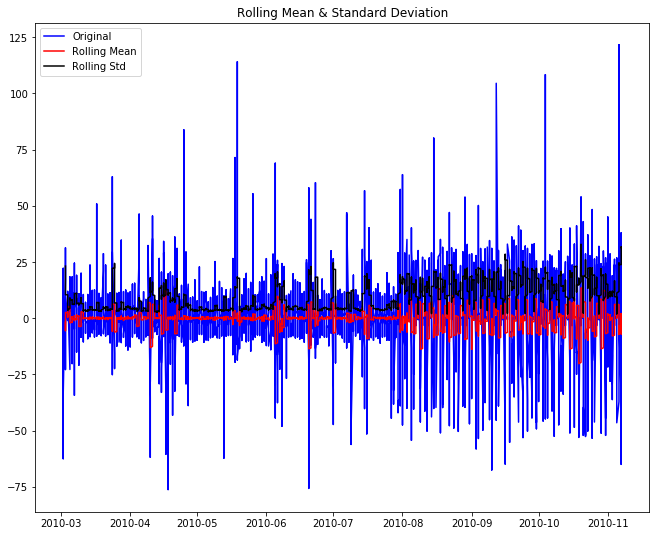

Results of Dickey-Fuller Test:
Test Statistic                   -30.135498
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    29993.000000
Critical Value (5%)               -2.861636
Critical Value (1%)               -3.430568
Critical Value (10%)              -2.566821
dtype: float64


In [63]:
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Note, the Test Statistic is "too small", compared to the critical values. 
We can apply ARIMA on residual or apply SARIMA on the original ts. Let's do the latter. 

### SARIMA model for the ts

SARIMA has different hyper-parameters. How to find them properly? 
 - In the following plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

    p:  The lag value where the PACF chart crosses the upper confidence interval for the first time. 
    
    q: The lag value where the ACF chart crosses the upper confidence interval for the first time. 
    
 - Define a grid search

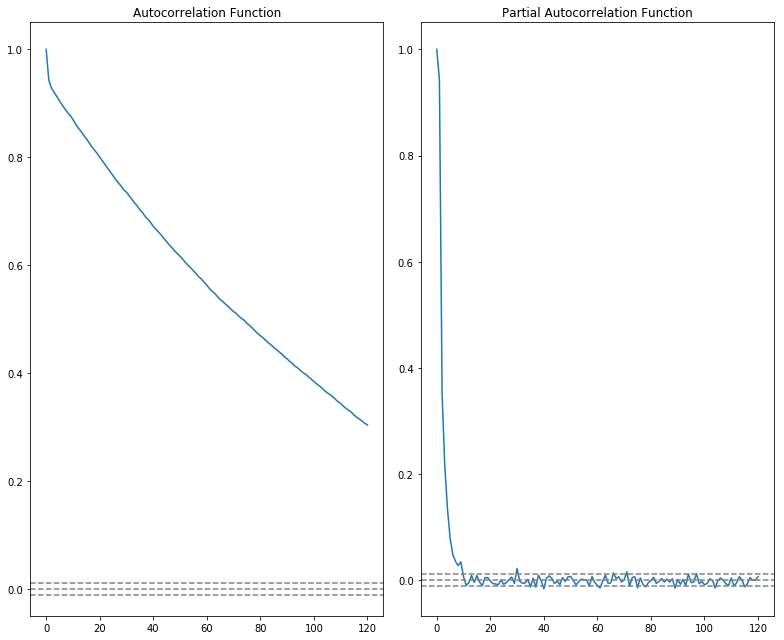

In [78]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts[1:], nlags=120)
lag_pacf = pacf(ts[1:], nlags=120, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Note: ACF is not proper. So, let's try the difference

In [79]:
ts_diff = ts - ts.shift(1)

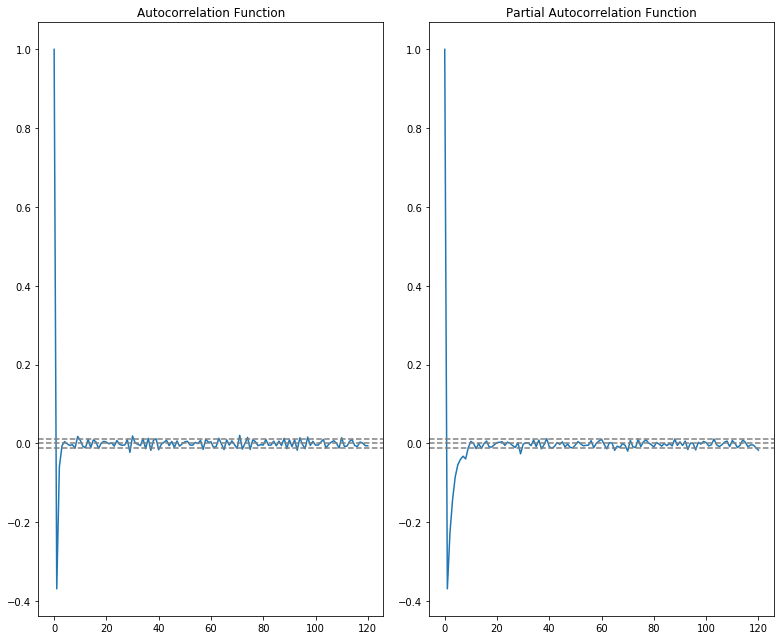

In [80]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff[1:], nlags=120)
lag_pacf = pacf(ts_diff[1:], nlags=120, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

So, it shows the difference could contribute. We also reduce the number of lags to 15 to save the time.


##### Grid search for tuning the parameter
The following code searches for the best parameters of SARIMA

In [ ]:
ps = range(0,5)
d=1 
qs = range(0, 2)
Ps = range(1, 5)
D=1 
Qs = range(0, 10)
s = 120 # season 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


def optimizeSARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ts, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


result_table = optimizeSARIMA(parameters_list, d, D, s)


Note: the grid search took a long time. Hence, I stoped the procedure. Suppose we have order=(0,1,0), seasonal_order=(1,1,1,15) as the optimal (the lowest AIC)

In [82]:
mod = sm.tsa.statespace.SARIMAX(ts_diff[1:25000], trend='n', order=(0,1,0), seasonal_order=(1,1,1,15))
results = mod.fit()
print results.summary()

/home/amin/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        travel_time   No. Observations:                24999
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 15)   Log Likelihood             -102324.083
Date:                            Mon, 22 Oct 2018   AIC                         204654.166
Time:                                    11:50:46   BIC                         204678.544
Sample:                                         0   HQIC                        204662.057
                                          - 24999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L15       0.0011      0.004      0.255      0.799      -0.007       0.009
ma.S.L15      -0.9999      0.004   

Now, test the model. Note that we tried "ts_diff".

The below, make a prediction on a part of dataset.

In [84]:
pred = results.get_prediction(start = 25001, end = 30161, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

/home/amin/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,lower travel_time,upper travel_time
25001,-61.406756,37.113440
25002,-68.388174,45.373150
25003,-75.439535,51.749492
25004,-81.915492,57.413106
25005,-87.177462,63.314624


Note: The above SARIMA is not accurate. We need to have a cross validation analysis there by Walk Forward Validation and spiliting the time series into a sequential part.

## Forecasting the Time Series (linear regression, random forest, etc)
#### Linear regression
I applied the folowing mask and then saved it to "40140_2.csv" file, then imported here.

Then, linear regression is performed. The dataset is divided into test and train for forcasting. However, we need cross validation here, if I have time.

Then, the same secario is followed for random forest. 

The most important freatures are aldo extractedd for further analysis.

##### Defining mask for holidays

I applied the folowing mask and then saved it to "40140_2.csv" file, then imported here.



In [ ]:
mask = (df_RTA2['Date'] >= '2010-04-02') & (df_RTA2['Date'] <= '2010-04-18') | (train['Date'] >= '2010-07-03') & (train['Date'] <= '2010-07-18') \
             | (df_RTA2['Date'] >= '2010-01-25') & (df_RTA2['Date'] <= '2010-10-10') | (train['Date']=='2010-01-01') | (train['Date']=='2010-01-26') \
            | (df_RTA2['Date']=='2010-04-02') | (df_RTA2['Date']=='2010-01-01') | (train['Date']=='2010-04-05') \
            | (df_RTA2['Date']=='2010-04-25') | (df_RTA2['Date']=='2010-05-09') | (train['Date']=='2010-06-14') \
            | (df_RTA2['Date']=='2010-10-04') | (df_RTA2['Weekday_name']=='Saturday') | (train['Weekday_name']=='Sunday')     

df_RTA2['Holidays']  = pd.Categorical(np.where(mask, 1, 0))



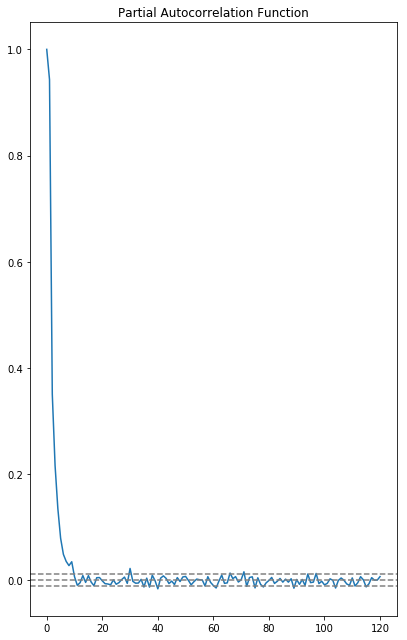

In [75]:
from statsmodels.tsa.stattools import acf, pacf
lag_pacf = pacf(ts[1:], nlags=120, method='ols')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

##### Note: we can use the lag_pacf features (maybe less than 15) for modelling approach.There are some other approaches to extract the lags which will see later. 
#### So, the  lag_pacf features can be feeded into the regression models.

In the following, I re-defined the time series, feeding holiday features into the ts. Then, shifting approach is followed to create lag features. 

In [92]:
ts = df_RTA2[['travel_time','Holidays']]
data = pd.DataFrame(ts.copy())
data.columns = ["y","y2"]
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)
    
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.predict(X_test)

array([1024.33637221, 1020.07490987, 1030.68406577, ..., 1071.93990619,
       1071.93181743, 1071.86523291])

##### Two new approaches to the above linear regression:
 - The above linear regression technique just use one fold cross validation. How about spiliting the time series into several spilits, for example 
  - Split 1: 5000 train, 5000 test
  - Split 2: 10000 train, 5000 test
  - Split 3: 15000 train, 5000 test
  - so on. Then, making ensemble by averaging all the results?
 - How about Walk Forward Validation technique which gives the model the best opportunity to make good forecasts at each time step, for example
  - train=501, test=1
  - train=502, test=1
  - train=503, test=1
  - train=504, test=1
  - so on. Then, making ensemble by averaging all the results? The disadvanages is being time-consuming




##### The below creates a 5 fold cross validation on the linear regression model (however, I prefer the Walk Forward Validation technique). This comes with two plots which the first shows plot modelled vs fact values, prediction intervals, and the latter shows sorted coefficient values of the model

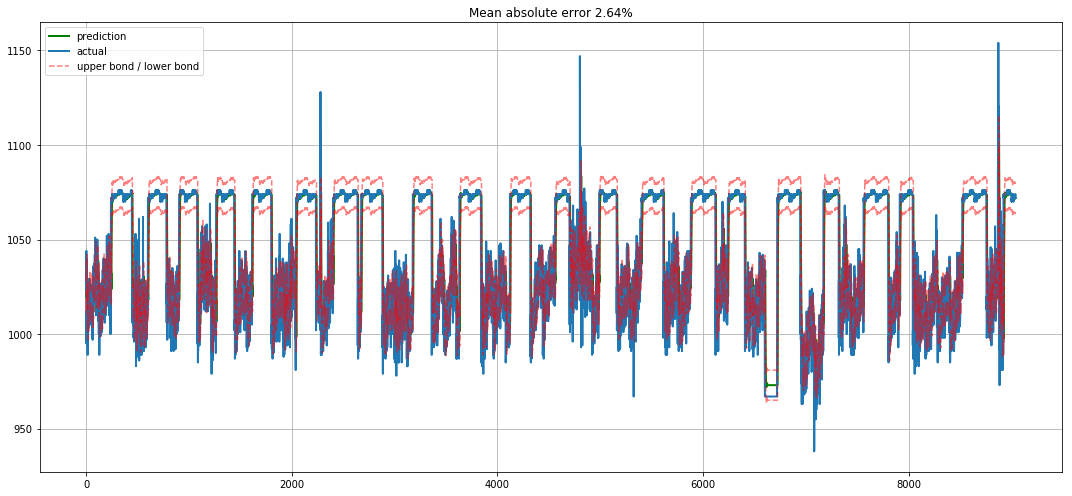

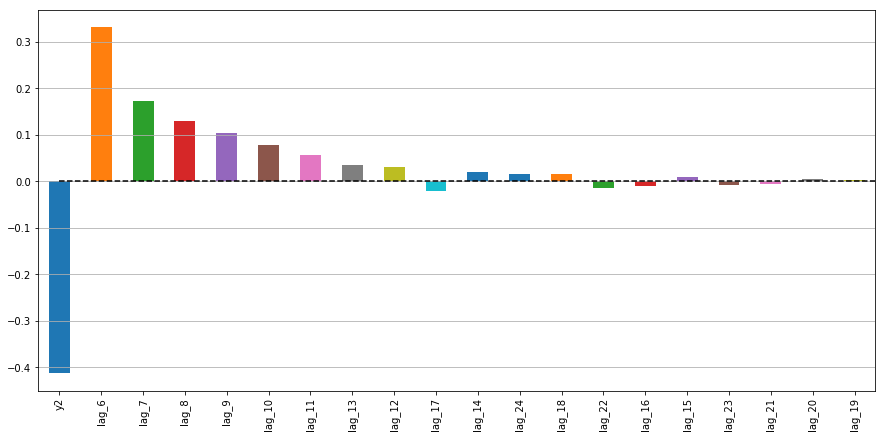

In [114]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

tscv = TimeSeriesSplit(n_splits=5)
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False):
    """
        Plots modelled vs fact values, prediction intervals
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
  
    error = median_absolute_error(prediction, y_test)
    plt.title("Mean absolute error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)


Note: I can apply the same scenario on different regression models, and present a comparison based on the values of different folds with the afore-mentioned metrics, by using box-plot. 

Just in case, as follows, I use another approach to extract the most important features by Random Forest. 

### Forcasting Random Forest
A shiffting technique is used to extract the features. 

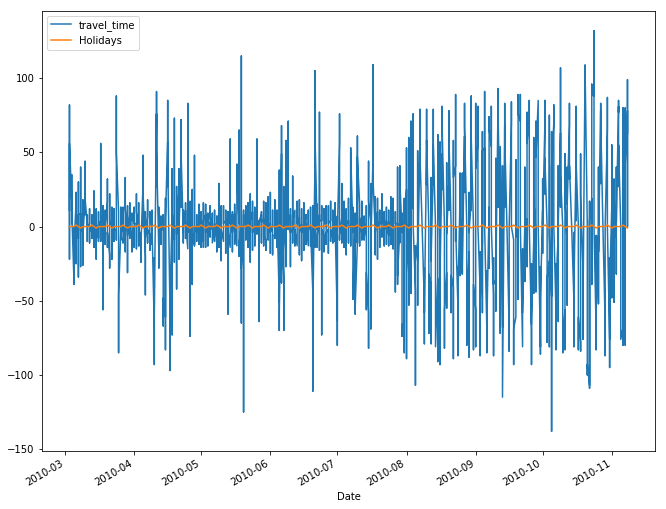

In [96]:
from matplotlib import pyplot
# seasonal difference
differenced = ts.diff(120)
# trim off the first year of empty data
differenced = differenced[120:]
# save differenced dataset to file
differenced.to_csv('seasonally_adjusted.csv')
# plot differenced dataset
differenced.plot()
pyplot.show()

In [115]:
from pandas import Series
from pandas import DataFrame

# load dataset
series = Series.from_csv('seasonally_adjusted.csv', header=None)
# reframe as supervised learning
dataframe = DataFrame()
for i in range(15,0,-1):
    dataframe['t-'+str(i)] = series.shift(i)
dataframe['t'] = series.values
# save to new file
dataframe.to_csv('lags_15_features.csv', index=False)

from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load data
dataframe = read_csv('lags_15_features.csv', header=0)
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

## Model Validation
Please note that just applying the trained model on a testset is not sufficient. For comparison, usually I use boxplot by look at the distributions of the results from cross validation. Kruskal-Wallis statistical test is also applied with an analysis on p-value. Usually, to conduct a result, different metrics I am using. 

 - For this specific regression model, it is worthwile to investigate the effect of lasso and rigid regularisations. 
 - Personally, I prefer using ensemble echniques. However, Random Forest is a sort of ensemble technique, it is great to combine different techniques which have different approch in terms of learning and regularity. 
 - For the ensemble techniques, I am more into using evalutionary techniques for tuning parameters, rather than applying voting there.

# Future work


## LSTM:
discuss similar to one of the task done before.

## Encoding Time Series as Images for Visual Inspection with CNN

# Questions

### How model changes when factors such as `car type (Bike, Car, Truck)`, `weather` and `traffic` are imported?
##### - Compleity
##### - Categorical
##### - Gain information

### What is the approach in rare events such as an accident?
##### - outliers and noise
##### - poisson regression